## 1. Importing Necessary Libraries


In [3]:
import numpy as np # For numerical operations
import pandas as pd # For data manipulation and analysis
import matplotlib.pyplot as plt # for plotting
from sklearn.impute import SimpleImputer # For handling missing values
from scipy.stats import pointbiserialr, chi2_contingency, skew # For statistical tests
from sklearn.preprocessing import StandardScaler, OneHotEncoder # For feature scaling and encoding
from sklearn.model_selection import train_test_split, GridSearchCV # For splitting data and for hyperparameter tuning
from sklearn.linear_model import LogisticRegression # For logistic regression model
from sklearn.tree import DecisionTreeClassifier  # For simple decision tree model
from sklearn.ensemble import RandomForestClassifier # For Random Forest model
import xgboost as xgb # For XGBoost model
from sklearn.pipeline import Pipeline # For creating a preprocessing and modelling pipeline
from sklearn.compose import ColumnTransformer # For applying transformers to specific columns
from sklearn.metrics import accuracy_score # For accuracy score
from category_encoders import TargetEncoder # For high cardinality encoding
from sklearn.metrics import classification_report

## 2. Data Loading and Initial Exploration

**Objective:** Load the data and undertsand its structure

### 2.1 Load Datasets

In [4]:
# Load training and test datasets
train_df = pd.read_csv('/kaggle/input/System-Threat-Forecaster/train.csv')
test_df = pd.read_csv('/kaggle/input/System-Threat-Forecaster/test.csv')

### 2.2 Display Dataset Shapes

In [3]:
print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)

Training data shape: (100000, 76)
Test data shape: (10000, 75)


#### Observations
* The **training dataset** contains **100000 rows and 76 columns.**
* The **test dataset** contains **10000 rows and 75 columns (excluding the target variable).**

### 2.3 Preview Training Data

In [4]:
print("\nFirst few rows of training data:")
print(train_df.head())


First few rows of training data:
                          MachineID   ProductName EngineVersion  \
0  f541bae429089117c4aac39c90dd3416  win8defender   1.1.15200.1   
1  dc2b14d9ce3a0ce4050bb640190f2ca5  win8defender   1.1.15100.1   
2  fd20c5f010e9c5f91ad1c6b3e0da68a0  win8defender   1.1.15200.1   
3  38711eae85eb77a72ec5dfdf27eb2a76  win8defender   1.1.15200.1   
4  32607c9a543a9214e2c7e45800ed4849  win8defender   1.1.15200.1   

         AppVersion SignatureVersion  IsBetaUser  RealTimeProtectionState  \
0   4.18.1807.18075     1.275.1003.0           0                      7.0   
1   4.18.1807.18075     1.273.1465.0           0                      7.0   
2   4.18.1807.18075     1.275.1546.0           0                      7.0   
3  4.12.17007.18011     1.275.1141.0           0                      7.0   
4    4.13.17134.228     1.275.1283.0           0                      7.0   

   IsPassiveModeEnabled  AntivirusConfigID  NumAntivirusProductsInstalled  \
0                     0

### 2.4 Display Data Info

In [5]:
print("\nInfo of columns:")
print(train_df.info())


Info of columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   MachineID                           100000 non-null  object 
 1   ProductName                         100000 non-null  object 
 2   EngineVersion                       100000 non-null  object 
 3   AppVersion                          100000 non-null  object 
 4   SignatureVersion                    100000 non-null  object 
 5   IsBetaUser                          100000 non-null  int64  
 6   RealTimeProtectionState             99934 non-null   float64
 7   IsPassiveModeEnabled                100000 non-null  int64  
 8   AntivirusConfigID                   99924 non-null   float64
 9   NumAntivirusProductsInstalled       99924 non-null   float64
 10  NumAntivirusProductsEnabled         99924 non-null   float64
 11  HasTpm   

#### Observations
* The dataset has a **mix** of **numerical and categorical features**.

### 2.5. The Dataset is balanced

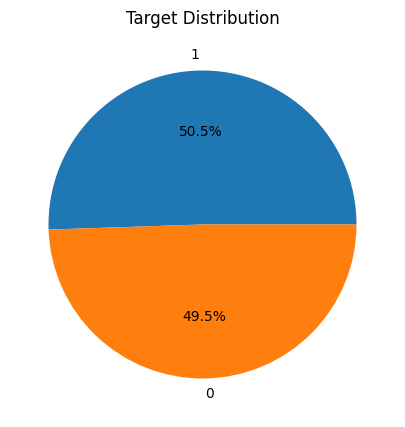

In [6]:
plt.figure(figsize=(8,5))
target_dist = train_df['target'].value_counts()
plt.pie(target_dist, labels=target_dist.index, autopct='%1.1f%%')
plt.title('Target Distribution')
plt.show()

#### Observations
* The pie chart illustrates that the target variable is nearly evenly distributed between the two classes, with **50.5%** of the data belonging to **class 1** and **49.5%** to **class 0**. This indicates a **balanced dataset** for the classification task.

## 3. Data Cleaning & Feature Engineering

**Objective:** Prepare the data by removing unnecessary columns and engineering new features.

### 3.1. Dropping 'MachineID' Column

In [7]:
train_df['MachineID'].nunique()

99835

In [8]:
train_df = train_df.drop('MachineID', axis=1)
test_df = test_df.drop('MachineID', axis=1)

# Result: Updated shaped after dropping 'MachineID'

print("\nTraining data shape after dropping MachineID:", train_df.shape)
print("\nTest data shape after dropping MachineID:", test_df.shape)


Training data shape after dropping MachineID: (100000, 75)

Test data shape after dropping MachineID: (10000, 74)


#### Observations
* Dropped **MachineID** as it has **approximately 100000 rows** which is close to observations in train_df, that means it's a unique identifier and most probably will not contribute in the prediction

### 3.2 Process Date Columnns

In [9]:
# Convert dates and extract year, month, day
for col in ['DateAS', 'DateOS']:
    train_df[col] = pd.to_datetime(train_df[col])
    test_df[col] = pd.to_datetime(test_df[col])
    train_df[f"{col}_year"] = train_df[col].dt.year
    train_df[f"{col}_month"] = train_df[col].dt.month
    train_df[f"{col}_day"] = train_df[col].dt.day
    test_df[f"{col}_year"] = test_df[col].dt.year
    test_df[f"{col}_month"] = test_df[col].dt.month
    test_df[f"{col}_day"] = test_df[col].dt.day
    train_df = train_df.drop(col, axis=1)
    test_df = test_df.drop(col, axis=1)

In [10]:
print("\nSample of new temporal features (training data)")
print(train_df[["DateAS_year", "DateAS_month", "DateAS_day", "DateOS_year", "DateOS_month", "DateOS_day"]])


Sample of new temporal features (training data)
       DateAS_year  DateAS_month  DateAS_day  DateOS_year  DateOS_month  \
0             2018             9          10       2018.0           4.0   
1             2018             8          16       2018.0           8.0   
2             2018             9          20       2018.0           9.0   
3             2018             9          14       2018.0           1.0   
4             2018             9          15       2018.0           9.0   
...            ...           ...         ...          ...           ...   
99995         2018             9          21       2018.0           9.0   
99996         2018             8          10       2018.0           7.0   
99997         2018             8          26       2018.0           3.0   
99998         2018             6           4       2018.0           5.0   
99999         2018             7          14       2018.0           8.0   

       DateOS_day  
0            17.0  
1         

#### Observations
* The date columns (`DateAS` and `DateOS`) were converted into a more usable format. Extracted the year, month, and day from each and added them as new features.
* The original date columns were then removed to avoid redundancy. This provides the model with separate numerical features for year, month, and day, potentially capturing temporal patterns.

### 2.3 Identify Column Types

In [5]:
categorical_columns = train_df.select_dtypes(include="object").columns.tolist()
numerical_columns = train_df.select_dtypes(exclude="object").columns.drop("target").tolist()

In [6]:
numerical_columns

['IsBetaUser',
 'RealTimeProtectionState',
 'IsPassiveModeEnabled',
 'AntivirusConfigID',
 'NumAntivirusProductsInstalled',
 'NumAntivirusProductsEnabled',
 'HasTpm',
 'CountryID',
 'CityID',
 'GeoRegionID',
 'LocaleEnglishNameID',
 'OSBuildNumber',
 'OSProductSuite',
 'IsSystemProtected',
 'AutoSampleSubmissionEnabled',
 'SMode',
 'IEVersionID',
 'FirewallEnabled',
 'EnableLUA',
 'OEMNameID',
 'OEMModelID',
 'ProcessorCoreCount',
 'ProcessorManufacturerID',
 'ProcessorModelID',
 'PrimaryDiskCapacityMB',
 'SystemVolumeCapacityMB',
 'HasOpticalDiskDrive',
 'TotalPhysicalRAMMB',
 'PrimaryDisplayDiagonalInches',
 'PrimaryDisplayResolutionHorizontal',
 'PrimaryDisplayResolutionVertical',
 'InternalBatteryNumberOfCharges',
 'OSBuildNumberOnly',
 'OSBuildRevisionOnly',
 'OSInstallLanguageID',
 'OSUILocaleID',
 'IsPortableOS',
 'IsFlightsDisabled',
 'FirmwareManufacturerID',
 'FirmwareVersionID',
 'IsSecureBootEnabled',
 'IsVirtualDevice',
 'IsTouchEnabled',
 'IsPenCapable',
 'IsAlwaysOnAlway

In [12]:
print("\nLength of Categorical Column list:", len(categorical_columns))
print("\nLength of Numerical Column list excluding target:", len(numerical_columns))


Length of Categorical Column list: 25

Length of Numerical Column list excluding target: 53


#### Observations
* Features were categorized into **numerical** and **categorical** types. This is important because **different preprocessing techniques are applied to each type**.
* This categorization ensures that we use the **right strategies for handling missing values** and **encoding features** later in the pipeline.

## 4. Handling Missing Values

**Objective:** Identify and impute numerical missing values to ensure numerical data completeness.

### 4.1 Check Missing Values

In [13]:
missing_train = train_df.isnull().sum()
missing_test = test_df.isnull().sum()

In [14]:
print("\nMissing values in Training Data:")
print(missing_train[missing_train > 0])
print("\nMissing values in Test Data")
print(missing_test[missing_test > 0])


Missing values in Training Data:
RealTimeProtectionState                66
AntivirusConfigID                      76
NumAntivirusProductsInstalled          76
NumAntivirusProductsEnabled            76
CityID                                623
IsSystemProtected                      76
SMode                                 981
IEVersionID                           107
FirewallEnabled                       166
EnableLUA                              19
OEMNameID                             212
OEMModelID                            228
ProcessorCoreCount                     85
ProcessorManufacturerID                85
ProcessorModelID                       85
PrimaryDiskCapacityMB                 110
PrimaryDiskType                        23
SystemVolumeCapacityMB                110
TotalPhysicalRAMMB                    151
ChassisType                             2
PrimaryDisplayDiagonalInches           72
PrimaryDisplayResolutionHorizontal     72
PrimaryDisplayResolutionVertical       72


#### Observations
* The output shows that the **training** and **test datasets** contain **missing values in multiple columns.**

### 4.2 Visualize Missing Values

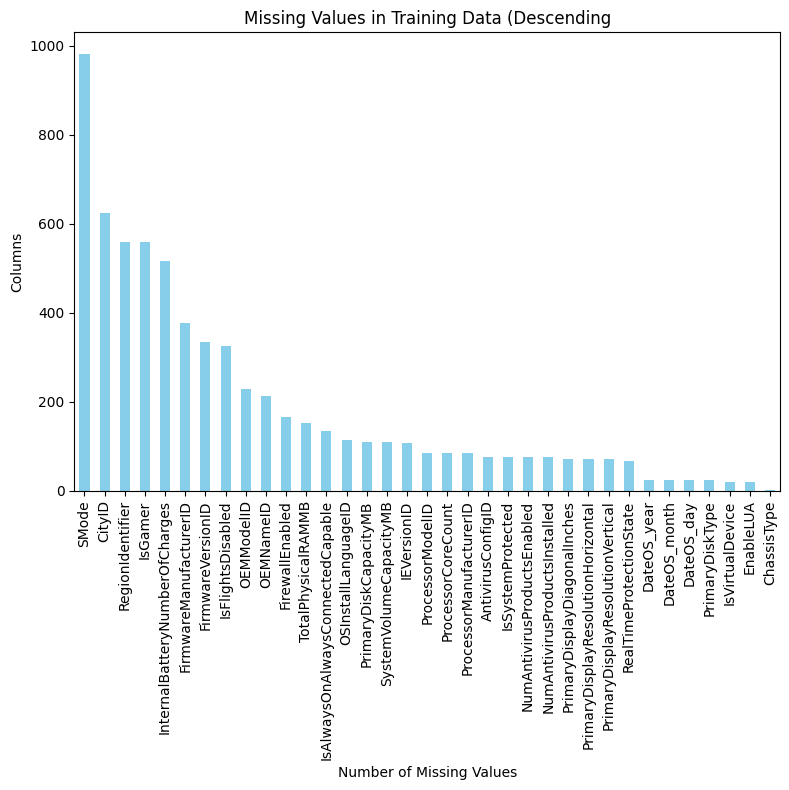

In [15]:
missing_train_filtered = missing_train[missing_train > 0].sort_values(ascending=False)
missing_test_filtered = missing_test[missing_test > 0].sort_values(ascending=False)
plt.figure(figsize=(8,8))
missing_train_filtered.plot(kind='bar', color='skyblue')
plt.title("Missing Values in Training Data (Descending")
plt.xlabel("Number of Missing Values")
plt.ylabel("Columns")
plt.tight_layout()
plt.show()

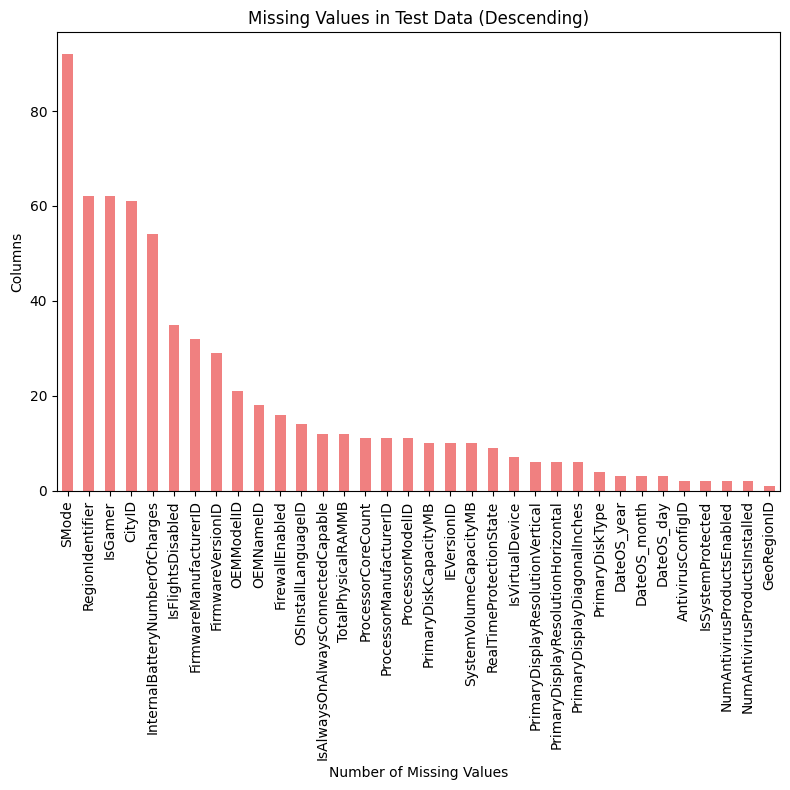

In [16]:
# Visualization for test dataset
plt.figure(figsize=(8,8))
missing_test_filtered.plot(kind="bar", color="lightcoral")
plt.title("Missing Values in Test Data (Descending)")
plt.xlabel("Number of Missing Values")
plt.ylabel("Columns")
plt.tight_layout()
plt.show()

#### Observations
* The bar charts generated further visualize the distribution of missing values, confirming observations from section 4.1.
* This visualization highlights the columns with the highest proportions of missing data in descending order, allowing for easy prioritization of the imputation process.

### 4.3 Impute Numerical Missing Values

In [17]:
num_imputer = SimpleImputer(strategy='median')
train_df[numerical_columns] = num_imputer.fit_transform(train_df[numerical_columns])
test_df[numerical_columns] = num_imputer.transform(test_df[numerical_columns])
print("\nMissing numerical values after imputation (train):", train_df[numerical_columns].isnull().sum().sum())
print("\nMissing numerical values after imputation (test):", test_df[numerical_columns].isnull().sum().sum())


Missing numerical values after imputation (train): 0

Missing numerical values after imputation (test): 0


#### Observations
- Post-imputation, **the sum of missing values in numerical columns is 0 for both datasets**, indicating successful **replacement with medians.**
- This **preserves** all rows, **avoiding data loss**
- The **median strategy ensures robustness against skewness.**
- Categorical missing values remain for separate handling.

## 5. Exploratory Data Analysis (EDA)

**Objective:** Analyze feature distributions and relationships with the target.

### 5.1 Analyze Skewness of Numerical Features

In [18]:
skewness = train_df[numerical_columns].skew()
skew_df = pd.DataFrame(skewness, columns=['skewness']).sort_values('skewness', ascending=False)
print("\nSkewness of numerical features:")
print(skew_df)


Skewness of numerical features:
                                      skewness
EnableLUA                           164.081602
SMode                                44.688482
IsPortableOS                         43.819346
IsVirtualDevice                      16.044571
TotalPhysicalRAMMB                    7.923699
IsPassiveModeEnabled                  7.333024
NumAntivirusProductsEnabled           5.551209
PrimaryDisplayDiagonalInches          5.349948
OSBuildRevisionOnly                   5.181163
IsPenCapable                          4.656783
IsAlwaysOnAlwaysConnectedCapable      3.769501
ProcessorCoreCount                    3.438949
IEVersionID                           3.350761
HasOpticalDiskDrive                   3.061684
PrimaryDisplayResolutionVertical      2.779402
PrimaryDisplayResolutionHorizontal    2.429738
IsTouchEnabled                        2.220692
DateOS_day                            1.705569
SystemVolumeCapacityMB                1.625266
NumAntivirusProductsInstall

#### 5.1.1 Visualization of Skewness

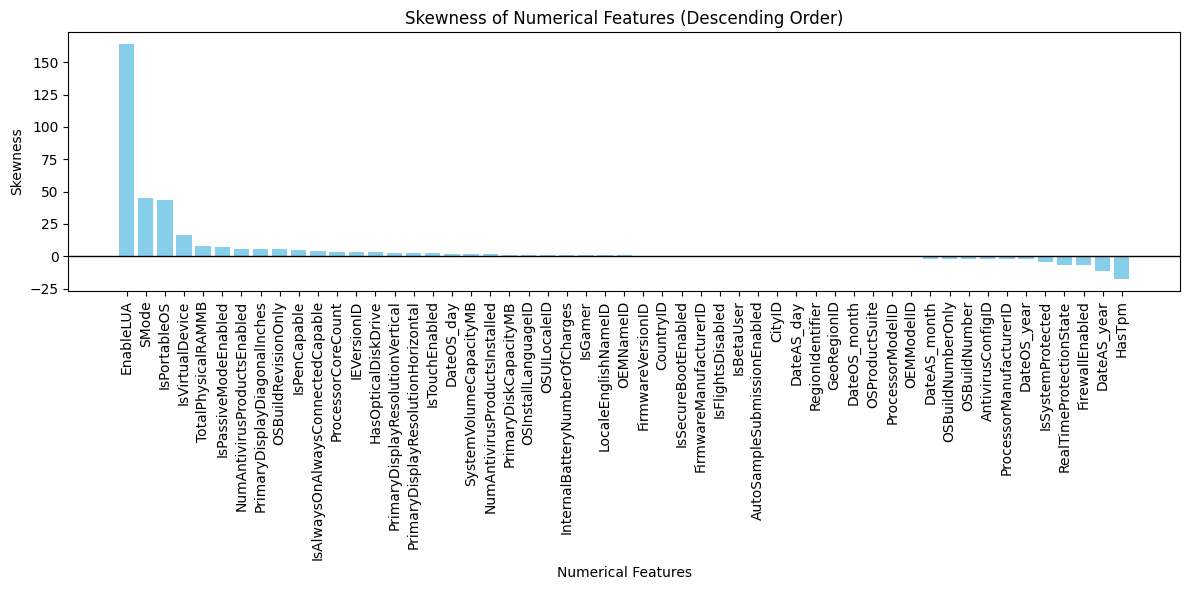

In [19]:
plt.figure(figsize=(12,6))
plt.bar(skew_df.index, skew_df['skewness'], color='skyblue')
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.title('Skewness of Numerical Features (Descending Order)')
plt.xlabel('Numerical Features')
plt.ylabel('Skewness')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### Observations
* The analysis reveals that **several numerical features exhibit significant skewness.**
* Some features have **negative skewness but are close to 0.**
* **High skewness** can potentially **influence the performance of machine learning models**. It is something to consider for potential transformations during preprocessing.

### 5.2 Analyze Outliers in Numerical Features

In [20]:
outlier_counts = {}
for col in numerical_columns:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    outliers = train_df[(train_df[col] < lower_bound) | (train_df[col] > upper_bound)][col]
    outlier_counts[col] = len(outliers)

In [21]:
outlier_counts

{'IsBetaUser': 0,
 'RealTimeProtectionState': 2559,
 'IsPassiveModeEnabled': 1762,
 'AntivirusConfigID': 19581,
 'NumAntivirusProductsInstalled': 96,
 'NumAntivirusProductsEnabled': 2259,
 'HasTpm': 322,
 'CountryID': 0,
 'CityID': 0,
 'GeoRegionID': 0,
 'LocaleEnglishNameID': 0,
 'OSBuildNumber': 15982,
 'OSProductSuite': 0,
 'IsSystemProtected': 4464,
 'AutoSampleSubmissionEnabled': 0,
 'SMode': 50,
 'IEVersionID': 4949,
 'FirewallEnabled': 1990,
 'EnableLUA': 487,
 'OEMNameID': 10270,
 'OEMModelID': 755,
 'ProcessorCoreCount': 11142,
 'ProcessorManufacturerID': 11735,
 'ProcessorModelID': 10931,
 'PrimaryDiskCapacityMB': 66,
 'SystemVolumeCapacityMB': 847,
 'HasOpticalDiskDrive': 8140,
 'TotalPhysicalRAMMB': 7094,
 'PrimaryDisplayDiagonalInches': 10749,
 'PrimaryDisplayResolutionHorizontal': 1035,
 'PrimaryDisplayResolutionVertical': 1899,
 'InternalBatteryNumberOfCharges': 0,
 'OSBuildNumberOnly': 15449,
 'OSBuildRevisionOnly': 14258,
 'OSInstallLanguageID': 2256,
 'OSUILocaleID': 

In [22]:
outlier_df = pd.DataFrame.from_dict(outlier_counts, orient='index', columns=['outlier_count']).sort_values('outlier_count', ascending=False)
# outlier_df[outlier_counts > 0]
print("\nNumber of ouliers in numerical features (IQR method):")
print(outlier_df)


Number of ouliers in numerical features (IQR method):
                                    outlier_count
AntivirusConfigID                           19581
DateOS_year                                 18620
OSBuildNumber                               15982
OSBuildNumberOnly                           15449
OSBuildRevisionOnly                         14258
IsTouchEnabled                              12847
ProcessorManufacturerID                     11735
ProcessorCoreCount                          11142
ProcessorModelID                            10931
PrimaryDisplayDiagonalInches                10749
OEMNameID                                   10270
DateOS_day                                  10046
HasOpticalDiskDrive                          8140
TotalPhysicalRAMMB                           7094
DateAS_month                                 6562
IsAlwaysOnAlwaysConnectedCapable             5832
IEVersionID                                  4949
IsSystemProtected                            

#### 5.2.1 Visualization of Outlier Count

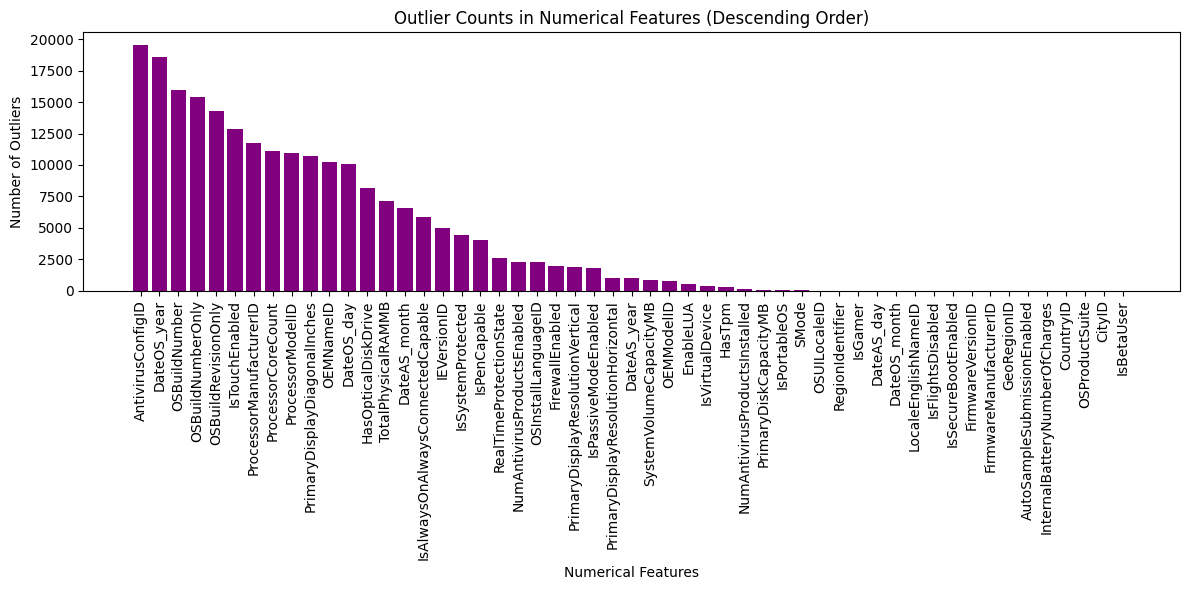

In [23]:
plt.figure(figsize=(12,6))
plt.bar(outlier_df.index, outlier_df['outlier_count'], color='purple')
plt.title("Outlier Counts in Numerical Features (Descending Order)")
plt.xlabel('Numerical Features')
plt.ylabel('Number of Outliers')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### Observations
* **Outlier analysis** reveals that features have a **notable number of outliers based on IQR method.**
* These outliers might need to be addressed depending on the model as some models are sensitive towards outliers.

### 5.3 Analyze Numerical Feature Relationships with Target

In [24]:
num_corr_values = {}
num_p_values = {}
for features in numerical_columns:
    corr, p = pointbiserialr(train_df[features], train_df['target'])
    num_corr_values[features] = corr
    num_p_values[features] = p

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


In [25]:
num_corr_values
num_p_values

{'IsBetaUser': nan,
 'RealTimeProtectionState': 3.6407486790928297e-54,
 'IsPassiveModeEnabled': 2.783914679436808e-40,
 'AntivirusConfigID': 1.247850301539505e-307,
 'NumAntivirusProductsInstalled': 0.0,
 'NumAntivirusProductsEnabled': 2.2563671106502247e-39,
 'HasTpm': 0.01545366764788138,
 'CountryID': 0.14433848580175665,
 'CityID': 0.14754889533969098,
 'GeoRegionID': 0.37564103397271204,
 'LocaleEnglishNameID': 9.696347040742345e-07,
 'OSBuildNumber': 4.768393869558828e-28,
 'OSProductSuite': 1.326464550050277e-10,
 'IsSystemProtected': 1.2996407387076987e-86,
 'AutoSampleSubmissionEnabled': nan,
 'SMode': 1.0380067198197009e-06,
 'IEVersionID': 5.0369664883987554e-14,
 'FirewallEnabled': 0.0012129122835639744,
 'EnableLUA': 0.5421314684233118,
 'OEMNameID': 0.00021167823579246948,
 'OEMModelID': 0.7535360172504447,
 'ProcessorCoreCount': 4.1284325776628613e-72,
 'ProcessorManufacturerID': 0.3315541330664362,
 'ProcessorModelID': 7.13107864162203e-12,
 'PrimaryDiskCapacityMB': 2.

In [26]:
num_corr_df = pd.DataFrame.from_dict(num_corr_values, orient='index', columns=['correlation'])
# num_corr_df
num_p_df = pd.DataFrame.from_dict(num_p_values, orient='index', columns=['p_value'])
# num_p_df

In [27]:
print("\nPoint-Biserial Correlation for numerical features vs. target:")
print(num_corr_df.sort_values('correlation', ascending=False))
print("\nCorresponding p-values:")
print(num_p_df.reindex(num_corr_df.index))


Point-Biserial Correlation for numerical features vs. target:
                                    correlation
AntivirusConfigID                      0.118146
TotalPhysicalRAMMB                     0.065683
IsSystemProtected                      0.062318
IsGamer                                0.060901
ProcessorCoreCount                     0.056744
PrimaryDiskCapacityMB                  0.049087
RealTimeProtectionState                0.048977
DateAS_month                           0.045492
OSBuildNumberOnly                      0.038544
PrimaryDisplayDiagonalInches           0.035061
OSBuildNumber                          0.034712
DateOS_year                            0.033950
PrimaryDisplayResolutionHorizontal     0.030570
DateAS_year                            0.026276
IEVersionID                            0.023812
HasOpticalDiskDrive                    0.022328
ProcessorModelID                       0.021675
InternalBatteryNumberOfCharges         0.016712
LocaleEnglishNameID      

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

#### 5.3.1 Visualization of Numerical Features vs. Target

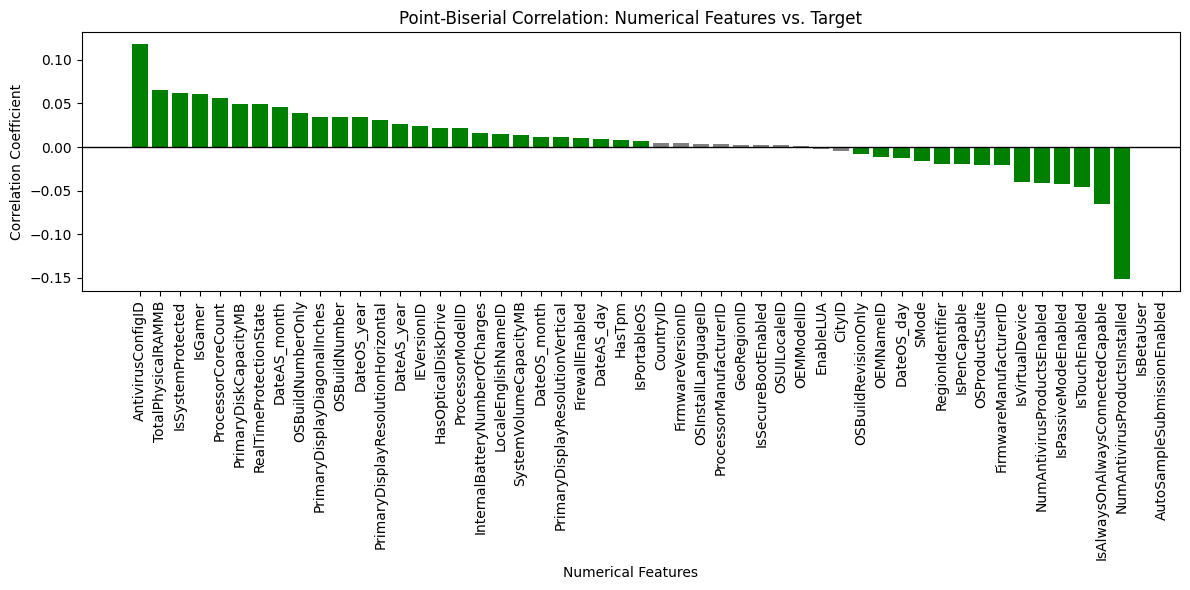

In [28]:
plt.figure(figsize=(12,6))
num_corr_df_sorted = num_corr_df.sort_values('correlation', ascending=False)
colors = ['green' if p < 0.05 else 'grey' for p in num_p_df.reindex(num_corr_df_sorted.index)['p_value']]
plt.bar(num_corr_df_sorted.index, num_corr_df_sorted['correlation'], color=colors)
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.title('Point-Biserial Correlation: Numerical Features vs. Target')
plt.xlabel('Numerical Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### Observations
* The **point-biserial correlation analysis** provides insights into the **relationship between numerical features and target variable.**
* While some features show a **weak positive or negative correlation with the target**, the **bars in the grey color are close to zero suggesting a weak or negligible relationship.**

### 5.4 Analyze Cardinality of Categorical Features

In [29]:
cardinality = train_df[categorical_columns].nunique()
card_df = pd.DataFrame(cardinality, columns=['cardinality']).sort_values('cardinality', ascending=False)
print("\nCardinality of categorical features:")
print(card_df)


Cardinality of categorical features:
                          cardinality
SignatureVersion                 2735
OSBuildLab                        281
NumericOSVersion                  221
AppVersion                         69
EngineVersion                      37
ChassisType                        28
OSEdition                          20
OSSkuFriendlyName                  18
OSBranch                           13
MDC2FormFactor                     11
OSInstallType                       9
OsPlatformSubRelease                9
PowerPlatformRole                   9
SKUEditionName                      8
OSVersion                           7
FlightRing                          7
AutoUpdateOptionsName               6
LicenseActivationChannel            6
OSGenuineState                      4
PrimaryDiskType                     4
PlatformType                        4
OSArchitecture                      3
Processor                           3
DeviceFamily                        2
ProductName 

#### 5.4.1 Visualization of Cardinality

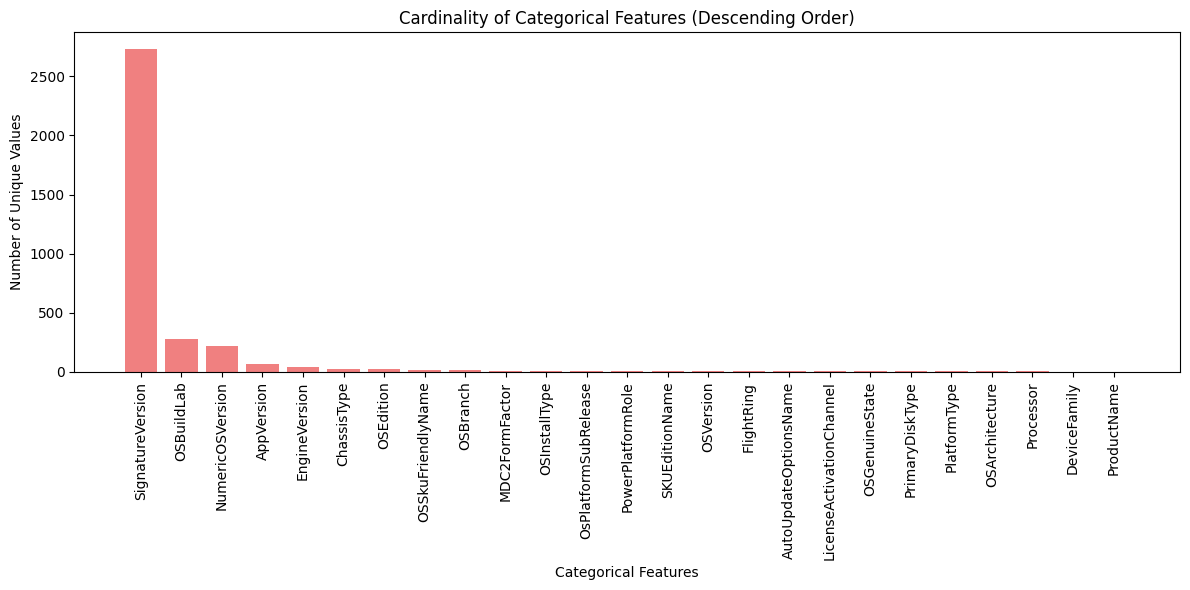

In [30]:
plt.figure(figsize=(12,6))
plt.bar(card_df.index, card_df['cardinality'],color='lightcoral')
plt.title("Cardinality of Categorical Features (Descending Order)")
plt.xlabel("Categorical Features")
plt.ylabel("Number of Unique Values")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### Observations
* Some Features exhibit **very high cardinality, indicating a large number of unique values** within these features.
* This high cardinality could potentially lead to challenges in modeling due to increased dimensionality and the risk of overfitting.
* Certain features have relatively `low cardinality`. This indicates a smaller number of unique categories and could be suitable for `one-hot encoding`.

### 5.5 Analyze Categorical Feature Relationships with Target using Chi Square Test of Independence

In [31]:
chi2_p_values = {}
for feature in categorical_columns:
    contingency_table = pd.crosstab(train_df[feature], train_df['target'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    chi2_p_values[feature] = p
chi2_df = pd.DataFrame.from_dict(chi2_p_values, orient='index', columns=['p_value'])
print("\nChi-Square p-values for categorical features vs. target:")
print(chi2_df.sort_values('p_value'))


Chi-Square p-values for categorical features vs. target:
                                p_value
EngineVersion              0.000000e+00
AppVersion                6.951063e-255
SignatureVersion          4.437698e-122
Processor                 3.220071e-118
MDC2FormFactor            5.321240e-118
OSArchitecture            2.755280e-116
OSBuildLab                9.551195e-107
PowerPlatformRole          1.089144e-92
NumericOSVersion           1.136398e-91
OSBranch                   4.954056e-81
OSInstallType              4.742714e-61
ChassisType                3.206588e-60
LicenseActivationChannel   3.115026e-53
OsPlatformSubRelease       9.694104e-52
OSEdition                  2.062612e-40
OSSkuFriendlyName          1.047725e-39
AutoUpdateOptionsName      8.722363e-30
PrimaryDiskType            4.522265e-15
SKUEditionName             3.238133e-09
OSGenuineState             1.827422e-03
DeviceFamily               2.229257e-02
PlatformType               3.220133e-02
ProductName           

#### 5.5.1 Visualization of Categorical Features vs. Target

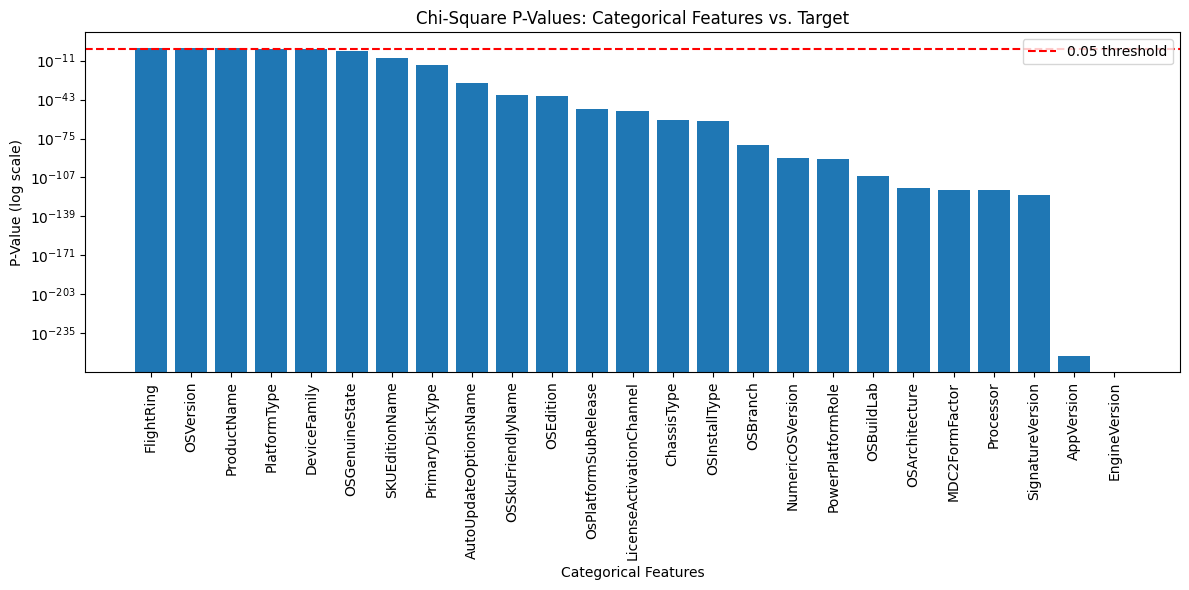

In [32]:
plt.figure(figsize=(12,6))
chi2_df_sorted = chi2_df.sort_values('p_value', ascending=False)
plt.bar(chi2_df_sorted.index, chi2_df_sorted['p_value'])
plt.yscale('log')
plt.axhline(y=0.05, color='red', linestyle='--', label='0.05 threshold')
plt.title('Chi-Square P-Values: Categorical Features vs. Target')
plt.xlabel('Categorical Features')
plt.ylabel('P-Value (log scale)')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

#### Observations
* The Chi-Square test for categorical features identifies a number of features with statistically significant relationships with the target variable `(p-value < 0.05)`

## 6. Feature Selection

**Objective:** Remove unnecessary features and retain only relevant ones.

### 6.1 Drop Constant Features

In [33]:
constant_features = ['IsBetaUser', 'AutoSampleSubmissionEnabled', 'IsFlightsDisabled']
for col in constant_features:
    print(f"\n{col} unique values:", train_df[col].unique())
    print(f"{col} NaN count:", train_df[col].isnull().sum())



IsBetaUser unique values: [0.]
IsBetaUser NaN count: 0

AutoSampleSubmissionEnabled unique values: [0.]
AutoSampleSubmissionEnabled NaN count: 0

IsFlightsDisabled unique values: [0.]
IsFlightsDisabled NaN count: 0


In [34]:
# Update train_df and test_df
train_df = train_df.drop(constant_features, axis=1, errors='ignore')
test_df = test_df.drop(constant_features, axis=1, errors='ignore')

In [35]:
# Update the numerical_columns after removing constant features
numerical_columns = [col for col in numerical_columns if col not in constant_features]

In [36]:
print("\nAfter removing constant features:")
print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)


After removing constant features:
Training data shape: (100000, 76)
Test data shape: (10000, 75)


#### Observations
* P-values for these features were `NaN`, indicating no statistical significance in distinguishing between target classes.
* Ensuring only features with variance are retained enhances the overall model’s ability to generalize.

### 6.2 Drop Numerical Columns

In [37]:
# # Concatinating num_corr_df, num_p_df, skew_df, outlier_df into num_features_df
# num_features_df = pd.concat([num_corr_df, num_p_df, skew_df, outlier_df], axis=1)

In [38]:
# num_to_drop = num_features_df[
#     (abs(num_features_df['correlation']) < 0.03) &    # Weak correlation
#     (num_features_df['p_value'] > 0.1) &             # p-value threshold
#     (abs(num_features_df['skewness']) < 10) &        # Moderate skewness
#     (num_features_df['outlier_count'] < 12000)       # outlier threshold
# ].index.tolist()

In [39]:
# num_to_drop

In [40]:
# train_df = train_df.drop(columns=num_to_drop, errors='ignore')
# test_df = test_df.drop(columns=num_to_drop, errors='ignore')

In [41]:
# len(numerical_columns)

In [42]:
# Update the list of numerical columns
# numerical_columns = [col for col in numerical_columns if col not in num_to_drop]

In [43]:
# len(numerical_columns)

In [44]:
# # Print results for verification
# print("\nInsignificant numerical features dropped:", num_to_drop)
# print("Remaining numerical columns:", numerical_columns)
# print("Training data shape after numerical drop:", train_df.shape)
# print("Test data shape after numerical drop:", test_df.shape)

#### Observations
* Several numerical features were identified as having weak correlation with the target variable `(correlation < 0.03)`, `high p-values (> 0.1)`, `moderate skewness ( < 10)`, and `a relatively low number of outliers (< 12000)`. These features were considered `insignificant and dropped`.
* Removing these features helps to simplify the model and reduce noise, potentially leading to better generalization performance.

### 6.3 Drop Categorical Features

In [45]:
# cat_features_df = pd.concat([chi2_df, card_df], axis=1)

In [46]:
# cat_to_drop = cat_features_df[
#     ((cat_features_df['p_value'] > 0.05) & (cat_features_df['cardinality'] <= 10)) |
#     ((cat_features_df['p_value'] > 0.1) & (cat_features_df['cardinality'] > 50))
# ].index.tolist()

In [47]:
# cat_to_drop

In [48]:
# # Remove the specified columns from train_df and test_df
# train_df = train_df.drop(columns=cat_to_drop, errors='ignore')
# test_df = test_df.drop(columns=cat_to_drop, errors='ignore')

In [49]:
# # Update the list of categorical columns
# categorical_columns = [col for col in categorical_columns if col not in cat_to_drop]

In [50]:
# # Print results for verification
# print("\nInsignificant categorical features dropped:", cat_to_drop)
# print("Remaining categorical columns:", categorical_columns)
# print("Final training data shape:", train_df.shape)
# print("Final test data shape:", test_df.shape)

In [51]:
# train_df.columns

In [52]:
# train_df['EngineVersion'].nunique()

In [53]:
# len(categorical_columns)

#### Observations
* Some categorical features with either `high p-values (> 0.05 for low cardinality, > 0.1 for high cardinality) or high cardinality` with limited predictive power were `removed` to simplify the model and prevent overfitting.
* `Reducing the number of features` helps to `improve model interpretability` and `reduces the risk of the model memorizing noise` in the data.

## 7. Feature Encoding and Scaling with Pipeline

**Objective:** To transform the dataset into a format suitable for machine learning models by encoding categorical features and scaling numerical features using a pipeline for efficiency and consistency.

### 7.1 Define Features and Split Cardinality

In [54]:
# print("\nStarting shapes:", train_df.shape, test_df.shape)
# print("Numerical columns:", numerical_columns)
# print("Categorical columns:", categorical_columns)

In [55]:
# low_cardinality = [col for col in categorical_columns if train_df[col].nunique() <= 10]
# high_cardinality = [col for col in categorical_columns if train_df[col].nunique() > 10]
# print("\nLow-cardinality categoricals (<= 10):", low_cardinality)
# print("High-cardinality categoricals (> 10):", high_cardinality)

#### Observations
* The code identifies and separates categorical features into `low-cardinality (<= 10 unique values)` and `high-cardinality (> 10 unique values)`. This distinction is crucial as different encoding strategies are applied to each type.

### 7.2 Define Preprocessing Pipeline

In [56]:
# # Numerical pipeline: StandardScaler
# numerical_pipeline = Pipeline(steps=[
#     ('scaler', StandardScaler())
# ])

# # Low-cardinality categorical pipeline: OneHotEncoder
# low_card_pipeline = Pipeline(steps=[
#     ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
# ])

# # High-cardinality categorical pipeline: TargetEncoder
# high_card_pipeline = Pipeline(steps=[
#     ('target_enc', TargetEncoder())
# ])

In [57]:
# # Numerical Pipeline
# numerical_pipeline

In [58]:
# # Low Cardinality Categorical Pipeline
# low_card_pipeline

In [59]:
# # High Cardinality Categorical Pipeline
# high_card_pipeline

In [60]:
# # Combine all transformations using ColumnTransformer
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_pipeline, numerical_columns),
#         ('low_card', low_card_pipeline, low_cardinality),
#         ('high_card', high_card_pipeline, high_cardinality)
#     ],
#     remainder='drop'  # Drop any columns not specified ('target' stays in train_df)
# )
# preprocessor

#### Observations
* Three separate pipelines are defined: `numerical_pipeline` for scaling numerical features using `StandardScaler`, `low_card_pipeline` for one-hot encoding low-cardinality categoricals using `OneHotEncoder`, and `high_card_pipeline` for target encoding high-cardinality categoricals using `TargetEncoder`
* hese pipelines are combined using `ColumnTransformer` to apply the appropriate transformations to the corresponding feature types.

### 7.3 Fit and Transform Training Data

In [61]:
# # Fit the preprocessor on training data and transform
# X_train_processed = preprocessor.fit_transform(X_train, y_train)
# X_test_processed = preprocessor.transform(X_test)

In [62]:
# # Get feature names after transformation
# num_features = numerical_columns
# low_card_features = preprocessor.named_transformers_['low_card'].named_steps['onehot'].get_feature_names_out(low_cardinality)
# high_card_features = high_cardinality
# all_features = list(num_features) + list(low_card_features) + list(high_card_features)

In [63]:
# # Convert to DataFrames
# X_train_processed_df = pd.DataFrame(X_train_processed, columns=all_features, index=X_train.index)
# X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_features, index=X_test.index)

In [64]:
# # Reattach target to training data
# train_df_processed = pd.concat([X_train_processed_df, y_train], axis=1)
# test_df_processed = X_test_processed_df

In [65]:
# # Final Verification
# print("Processed feature names:", all_features)
# print("Sample of processed training data:\n", train_df_processed.head())

#### Observations
* The preprocessor is fitted to the training data `(X_train)` using the target variable `(y_train)` for target encoding.
* Both the training and test data are transformed using the fitted preprocessor to ensure consistency in feature representation.
* The transformed data is converted back into pandas DataFrames for easier handling and analysis. The training data also has the target variable reattached.


## 7a. Feature Selection and Preprocessing Pipeline

**Objective:** To create a single, reusable pipeline that encapsulates feature selection, encoding, and scaling, thereby simplifying the data preparation process, improving efficiency, and enhancing reproducibility.

In [66]:
# Feature Selection Function
def select_features(X, y):
    num_df = pd.DataFrame(X[numerical_columns])
    num_analysis = pd.DataFrame(index=numerical_columns)

    num_analysis['correlation'] = [pointbiserialr(num_df[col], y)[0] 
                                   for col in numerical_columns]
    num_analysis['p_value'] = [pointbiserialr(num_df[col], y)[1] 
                               for col in numerical_columns]
    num_analysis['skewness'] = num_df.skew()
    
    num_analysis['outlier_count'] = [
        ((num_df[col] < num_df[col].quantile(0.25) - 1.5 * 
          (num_df[col].quantile(0.75) - num_df[col].quantile(0.25))) |
         (num_df[col] > num_df[col].quantile(0.75) + 1.5 * 
          (num_df[col].quantile(0.75) - num_df[col].quantile(0.25)))).sum()
        for col in numerical_columns
    ]

    selected_num = num_analysis[
        ~((abs(num_analysis['correlation']) < 0.03) &
          (num_analysis['p_value'] > 0.1) &
          (abs(num_analysis['skewness']) > 10) &
          (num_analysis['outlier_count'] > 12000))
    ].index.tolist()

    cat_df = pd.DataFrame(X[categorical_columns])
    cat_analysis = pd.DataFrame(index=categorical_columns)
    
    cat_analysis['cardinality'] = cat_df.nunique()
    cat_analysis['p_value'] = [chi2_contingency(pd.crosstab(cat_df[col], y))[1] 
                               for col in categorical_columns]

    selected_cat = cat_analysis[
        ~(((cat_analysis['p_value'] > 0.05) & (cat_analysis['cardinality'] <= 10)) |
          ((cat_analysis['p_value'] > 0.1) & (cat_analysis['cardinality'] > 50)))
    ].index.tolist()

    return selected_num, selected_cat


#### Observations
* Several numerical features were identified as having weak correlation with the target variable `(correlation < 0.03)`, `high p-values (> 0.1)`, `skewness ( > 10)`, and `number of outliers (> 12000)`. These features were considered `insignificant and dropped`.
* Removing these features helps to simplify the model and reduce noise, potentially leading to better generalization performance.
* Some categorical features with either `high p-values (> 0.05 for low cardinality, > 0.1 for high cardinality or high cardinality)` with limited predictive power were `removed` to simplify the model and prevent overfitting.
* `Reducing the number of features` helps to `improve model interpretability` and `reduces the risk of the model memorizing noise` in the data.

In [67]:
# Perform feature selection
X_train = train_df.drop('target', axis=1)
y_train = train_df['target']
selected_num_cols, selected_cat_cols = select_features(X_train, y_train)

In [68]:
# Verify columns in both DataFrames
print("X_train columns:", X_train.columns.tolist())
print("test_df columns:", test_df.columns.tolist())

X_train columns: ['ProductName', 'EngineVersion', 'AppVersion', 'SignatureVersion', 'RealTimeProtectionState', 'IsPassiveModeEnabled', 'AntivirusConfigID', 'NumAntivirusProductsInstalled', 'NumAntivirusProductsEnabled', 'HasTpm', 'CountryID', 'CityID', 'GeoRegionID', 'LocaleEnglishNameID', 'PlatformType', 'Processor', 'OSVersion', 'OSBuildNumber', 'OSProductSuite', 'OsPlatformSubRelease', 'OSBuildLab', 'SKUEditionName', 'IsSystemProtected', 'SMode', 'IEVersionID', 'FirewallEnabled', 'EnableLUA', 'MDC2FormFactor', 'DeviceFamily', 'OEMNameID', 'OEMModelID', 'ProcessorCoreCount', 'ProcessorManufacturerID', 'ProcessorModelID', 'PrimaryDiskCapacityMB', 'PrimaryDiskType', 'SystemVolumeCapacityMB', 'HasOpticalDiskDrive', 'TotalPhysicalRAMMB', 'ChassisType', 'PrimaryDisplayDiagonalInches', 'PrimaryDisplayResolutionHorizontal', 'PrimaryDisplayResolutionVertical', 'PowerPlatformRole', 'InternalBatteryNumberOfCharges', 'NumericOSVersion', 'OSArchitecture', 'OSBranch', 'OSBuildNumberOnly', 'OSBuil

In [69]:
# Ensure test_df has only the columns present in X_train that we need
common_columns = [col for col in X_train.columns if col in test_df.columns]
test_df = test_df[common_columns]  # Align test_df with X_train’s columns

In [70]:
# Define pipelines
numerical_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])
numerical_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('scale', StandardScaler())])

In [71]:
# Adjust categorical pipeline to use column indices instead of names dynamically
low_card_cols = [col for col in selected_cat_cols if train_df[col].nunique() <= 10]
high_card_cols = [col for col in selected_cat_cols if train_df[col].nunique() > 10]

In [72]:
categorical_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='constant',fill_value='missing')),
    ('encode', ColumnTransformer([
    ('low_card', OneHotEncoder(sparse_output=False, handle_unknown='ignore'),[selected_cat_cols.index(col) for col in low_card_cols]),
    ('high_card', TargetEncoder(), [selected_cat_cols.index(col) for col in high_card_cols])], remainder='passthrough'))
])
categorical_pipeline

Pipeline(steps=[('impute',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('encode',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('low_card',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  [3, 4, 5, 7, 9, 10, 12, 14,
                                                   18, 19, 20, 21]),
                                                 ('high_card', TargetEncoder(),
                                                  [0, 1, 2, 6, 8, 11, 13, 15,
                                                   16, 17])]))])

In [73]:
# Combined preprocessor with indices instead of column names
preprocessor = ColumnTransformer(
    transformers=[('num', numerical_pipeline, [X_train.columns.get_loc(col) for col in selected_num_cols]),
                  ('cat', categorical_pipeline, [X_train.columns.get_loc(col) for col in selected_cat_cols])],
    remainder='drop')
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scale', StandardScaler())]),
                                 [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 17, 18, 22,
                                  23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 36,
                                  37, 38, 40, 41, 42, 44, ...]),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('encode',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('low_card',
                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                 sparse_output=False),
                                                                                   [3,
                                                                                    4,
                                                                                    5,
                                                                                    7,
                                                                                    9,
                                                                                    10,
                                                                                    12,
                                                                                    14,
                                                                                    18,
                                                                                    19,
                                                                                    20,
                                                                                    21]),
                                                                                  ('high_card',
                                                                                   TargetEncoder(),
                                                                                   [0,
                                                                                    1,
                                                                                    2,
                                                                                    6,
                                                                                    8,
                                                                                    11,
                                                                                    13,
                                                                                    15,
                                                                                    16,
                                                                                    17])]))]),
                                 [1, 2, 3, 14, 15, 19, 20, 21, 27, 28, 35, 39,
                                  43, 45, 46, 47, 50, 51, 52, 55, 57, 58])])

In [74]:
# Full pipeline
full_pipeline = Pipeline([
    ('preprocessor', preprocessor)
])
full_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  [4, 5, 6, 7, 8, 9, 10, 11, 12,
                                                   13, 17, 18, 22, 23, 24, 25,
                                                   26, 29, 30, 31, 32, 33, 34,
                                                   36, 37, 38, 40, 41, 42, 44, ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encode',
                                                                   ColumnTransformer(remainder='passthrough',
                                                                                     transformers=[('low_card',
                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                  sparse_output=False),
                                                                                                    [3,
                                                                                                     4,
                                                                                                     5,
                                                                                                     7,
                                                                                                     9,
                                                                                                     10,
                                                                                                     12,
                                                                                                     14,
                                                                                                     18,
                                                                                                     19,
                                                                                                     20,
                                                                                                     21]),
                                                                                                   ('high_card',
                                                                                                    TargetEncoder(),
                                                                                                    [0,
                                                                                                     1,
                                                                                                     2,
                                                                                                     6,
                                                                                                     8,
                                                                                                     11,
                                                                                                     13,
                                                                                                     15,
     

In [75]:
# Process data
X_train_processed = full_pipeline.fit_transform(X_train, y_train)
X_test_processed = full_pipeline.transform(test_df)

#### Observations
* The full pipeline is fitted to the training data `(X_train)` using the target variable `(y_train)` for target encoding.
* Both the training and test data are transformed using the fitted **full pipeline** to ensure consistency in feature representation.
* The transformed data is converted back into pandas DataFrames for easier handling and analysis. The training data also has the target variable reattached.

In [76]:
# Get feature names
low_card_features = (full_pipeline.named_steps['preprocessor']
                    .named_transformers_['cat']
                    .named_steps['encode']
                    .named_transformers_['low_card']
                    .get_feature_names_out(low_card_cols) if low_card_cols else [])
all_features = selected_num_cols + list(low_card_features) + high_card_cols

In [77]:
# Create processed DataFrames
train_df_processed = pd.DataFrame(X_train_processed, columns=all_features)
train_df_processed['target'] = y_train.values
test_df_processed = pd.DataFrame(X_test_processed, columns=all_features)

In [78]:
# Verify
print("Final training shape:", train_df_processed.shape)
print("Final test shape:", test_df_processed.shape)
print("Processed feature names:", all_features)
print("Sample of processed training data:\n", train_df_processed.head())

Final training shape: (100000, 129)
Final test shape: (10000, 128)
Processed feature names: ['RealTimeProtectionState', 'IsPassiveModeEnabled', 'AntivirusConfigID', 'NumAntivirusProductsInstalled', 'NumAntivirusProductsEnabled', 'HasTpm', 'CountryID', 'CityID', 'GeoRegionID', 'LocaleEnglishNameID', 'OSBuildNumber', 'OSProductSuite', 'IsSystemProtected', 'SMode', 'IEVersionID', 'FirewallEnabled', 'EnableLUA', 'OEMNameID', 'OEMModelID', 'ProcessorCoreCount', 'ProcessorManufacturerID', 'ProcessorModelID', 'PrimaryDiskCapacityMB', 'SystemVolumeCapacityMB', 'HasOpticalDiskDrive', 'TotalPhysicalRAMMB', 'PrimaryDisplayDiagonalInches', 'PrimaryDisplayResolutionHorizontal', 'PrimaryDisplayResolutionVertical', 'InternalBatteryNumberOfCharges', 'OSBuildNumberOnly', 'OSBuildRevisionOnly', 'OSInstallLanguageID', 'OSUILocaleID', 'IsPortableOS', 'FirmwareManufacturerID', 'FirmwareVersionID', 'IsSecureBootEnabled', 'IsVirtualDevice', 'IsTouchEnabled', 'IsPenCapable', 'IsAlwaysOnAlwaysConnectedCapable'

#### Observations
* This section combines **feature selection and preprocessing into a single pipeline**, streamlining the data preparation process.
* By applying statistical analysis (**point-biserial correlation, p-values, skewness, outlier detection for numerical features**; **chi-squared tests and cardinality for categorical features**) within the pipeline, it selects only the most relevant features for the model, potentially improving efficiency and performance.
* The pipeline automatically applies appropriate encoding techniques based on cardinality (**OneHotEncoder for low cardinality**, **TargetEncoder for high cardinality**) and **scales numerical features using StandardScaler**.
*  Combining feature selection, preprocessing, and model training into a single pipeline enhances reproducibility and makes the code more maintainable by encapsulating all data transformations in a single, reusable object.

## 8. Modeling and Evaluation

**Objective:** To train and evaluate different machine learning models using the preprocessed data, compare their performance, and select the best model for predicting the target variable. 

### 8.1 Prepare Data

In [79]:
print("\nStarting shapes:", train_df_processed.shape, test_df_processed.shape)
X = train_df_processed.drop('target', axis=1)
y = train_df_processed['target']


Starting shapes: (100000, 129) (10000, 128)


In [80]:
# Split training data into train and validation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)

Train set shape: (80000, 128) (80000,)
Validation set shape: (20000, 128) (20000,)


#### Observations
* The preprocessed training data is split into training and validation sets using an 80-20 split with stratification to ensure similar target variable distributions in both sets.
* The training set contains 80,000 samples, while the validation set contains 20,000 samples.
* The `random_state` is set to 42 for reproducibility, ensuring that the data split remains consistent across different runs.

### 8.2 Train Model

#### 8.2.1 Logistic Regression

In [81]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=2000, random_state=42)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_val)
lr_accuracy = accuracy_score(y_val, lr_pred)

In [82]:
lr_accuracy

0.62705

In [83]:
print(classification_report(y_val, lr_pred))

              precision    recall  f1-score   support

           0       0.63      0.58      0.61      9895
           1       0.62      0.67      0.64     10105

    accuracy                           0.63     20000
   macro avg       0.63      0.63      0.63     20000
weighted avg       0.63      0.63      0.63     20000



#### Observations
* A logistic regression model is trained using the training data with a maximum of 1000 iterations and a random state of 42 for reproducibility.
* The trained model is used to predict the target variable for the validation set, and the accuracy score is calculated.
* The accuracy of the logistic regression model is approximately 0.62.

#### 8.2.2 Random Forest

In [84]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_val)
rf_accuracy = accuracy_score(y_val, rf_pred)

In [85]:
rf_accuracy

0.62615

In [86]:
print(classification_report(y_val, rf_pred))

              precision    recall  f1-score   support

           0       0.62      0.61      0.62      9895
           1       0.63      0.64      0.63     10105

    accuracy                           0.63     20000
   macro avg       0.63      0.63      0.63     20000
weighted avg       0.63      0.63      0.63     20000



#### Observations
* A random forest model is trained using the training data with 100 estimators (trees) and a random state of 42 for reproducibility.
* The trained model is used to predict the target variable for the validation set, and the accuracy score is calculated.
* The accuracy of the random forest model is approximately 0.62.

#### 8.2.3 XGBoost

In [87]:
# XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_val)
xgb_accuracy = accuracy_score(y_val, xgb_pred)

In [88]:
xgb_accuracy

0.6352

In [89]:
print(classification_report(y_val, xgb_pred))

              precision    recall  f1-score   support

           0       0.64      0.59      0.62      9895
           1       0.63      0.68      0.65     10105

    accuracy                           0.64     20000
   macro avg       0.64      0.63      0.63     20000
weighted avg       0.64      0.64      0.63     20000



#### Observations
* An XGBoost model is trained using the training data with default parameters and a random state of 42 for reproducibility.
* The trained model is used to predict the target variable for the validation set, and the accuracy score is calculated.
* The accuracy of the XGBoost model is approximately 0.635.

In [90]:
print("Logistic Regression", lr_accuracy)
print("Random Forest:", rf_accuracy)
print("XGBoost:", xgb_accuracy)

Logistic Regression 0.62705
Random Forest: 0.62615
XGBoost: 0.6352


In [91]:
best_model = max([("Random Forest", rf_accuracy),
                  ("XGBoost", xgb_accuracy),
                  ("Logistic Regression", lr_accuracy)],
                 key=lambda x: x[1])
print("Best Model:", best_model[0])

Best Model: XGBoost


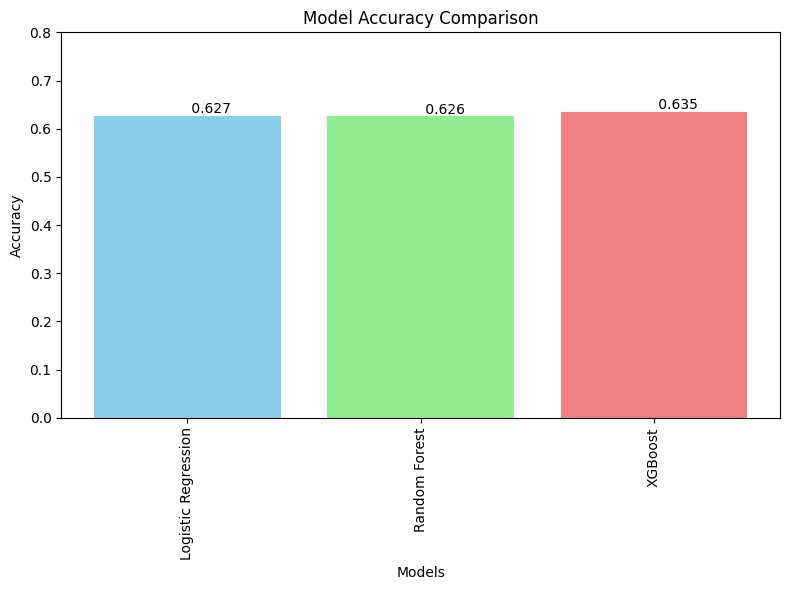

In [92]:
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
accuracies = [lr_accuracy, rf_accuracy, xgb_accuracy]

plt.figure(figsize=(8,6))
plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.ylim(0, 0.8)
plt.xticks(rotation=90)

for i, v in enumerate(accuracies):
    plt.text(i, v + 0.005, f'{v: .3f}')
plt.tight_layout()
plt.show()

### 8.3 Hyperparameter Tuning for XGBoost


In [93]:
# XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}
xgb_grid = GridSearchCV(xgb.XGBClassifier(random_state=42), 
                        xgb_param_grid, 
                        cv=5, 
                        scoring='accuracy', 
                        n_jobs=-1, 
                        verbose=2)
xgb_grid.fit(X_train, y_train)
print("Best XGBoost Params:", xgb_grid.best_params_)
print("Best XGBoost CV Score:", xgb_grid.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Best XGBoost CV Score: 0.6370625000000001


In [94]:
xgb_model_tuned = xgb.XGBClassifier(**xgb_grid.best_params_, random_state=42)
xgb_model_tuned.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [95]:
xgb_pred_tuned = xgb_model_tuned.predict(X_val)

In [96]:
xgb_accuracy_tuned = accuracy_score(y_val, xgb_pred_tuned)

In [97]:
print("XGBoost:", xgb_accuracy_tuned)

XGBoost: 0.64195


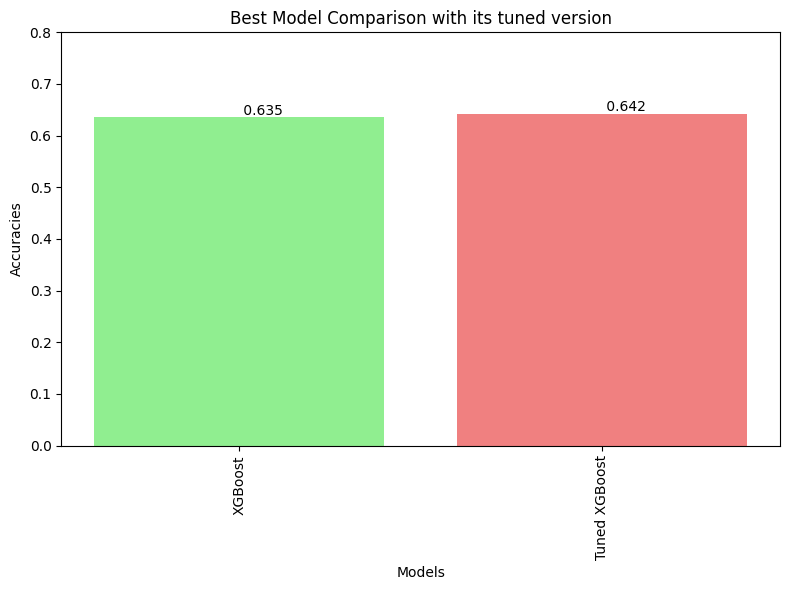

In [98]:
models = ['XGBoost', 'Tuned XGBoost']
accuracies = [xgb_accuracy, xgb_accuracy_tuned]

plt.figure(figsize=(8,6))
plt.bar(models, accuracies, color=['lightgreen', 'lightcoral'])
plt.title('Best Model Comparison with its tuned version')
plt.xlabel('Models')
plt.ylabel('Accuracies')
plt.ylim(0, 0.8)
plt.xticks(rotation=90)

for i, v in enumerate(accuracies):
    plt.text(i, v + 0.005, f'{v: .3f}')
plt.tight_layout()
plt.show()

#### Observations
* After hyperparameter tuning using **GridSearchCV**, the XGBoost model achieves a **higher accuracy (0.642) score on the validation set compared to the baseline XGBoost model (without tuning).**
* This improvement demonstrates the effectiveness of the tuning process in finding better hyperparameter values.

In [99]:
print(classification_report(y_val, xgb_pred_tuned))

              precision    recall  f1-score   support

           0       0.65      0.60      0.62      9895
           1       0.64      0.69      0.66     10105

    accuracy                           0.64     20000
   macro avg       0.64      0.64      0.64     20000
weighted avg       0.64      0.64      0.64     20000



## 9. Prediction and Submission

In [100]:
# # Prediction and Submission
test_pred = xgb_model_tuned.predict(X_test_processed) 

In [101]:
# submission_df = pd.DataFrame({
#     'id': range(len(test_df)),
#     'target': test_pred
# })

In [102]:
# submission_df.to_csv('submission.csv', index=False)
# print("\nSubmission file 'submission.csv' created successfully!")

In [103]:
# submission_df.head()

In [104]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.svm import SVC

In [105]:
# sv_model = SVC()

In [106]:
# param_grid={
#     'degree':3,
#     'tol':0.001
# }

In [107]:
# svc = RandomizedSearchCV(sv_model, param_grid, n_iter=5, cv=2, error_score='accuracy')